# Modeling extreme cases with peaks over threshold - 2
> Technical overview of peaks over threshold

- toc: true 
- badges: true
- comments: true
- author: Gieun Kwak
- categories: [extreme value statistics, peaks over threshold, statistics]

Packages used: <br>`extRemes`, `Rcpp`, `dplyr`

Readings: <br>[An introduction to extreme value statistics](http://grotjahn.ucdavis.edu/EWEs/extremes_primer_v9_22_15.pdf),  <br>[An introduction to statistical modeling of extreme values](https://pdfcoffee.com/anintroductiontostatisticalmodelingofextremevalues-pdf-free.html), <br>[극단치이론을 이용한 VaR의 추정과 검증 : 국내 주식시장을 중심으로](https://academic.naver.com/article.naver?doc_id=30889225)

-----

### Overview

&emsp;We'll dive right into the analysis of peaks over threshold, using sample data.<br>
Peaks over threshold method sets a threshold to sort out the data it wants to model. Also, it is a parametric method, meaning that we want to find parameters that would create a distribution that fits the data.
&emsp;Below are the characteristics of peaks over threshold:
- Follows a Generalized Pareto (GP) distribution
- In mathematical terms, $G(y) = 1 - [1 + \frac{\xi (y-\mu)}{\sigma} ]^{\frac{- 1}{\xi}}$
    - $\mu$ is the threshold
    - $\sigma$ is the scale parameter
    - $\xi$ is the shape parameter

In [19]:
# collapse

options(warn=0)

library(extRemes)
library(Rcpp)
library(ggplot2)
library(dplyr)
library(VGAM)
library(repr)
options(repr.plot.width=10, repr.plot.height=7)

### How the GP distribution looks like:

&emsp;Below is the plot where $\sigma$ changes while $\xi=0$

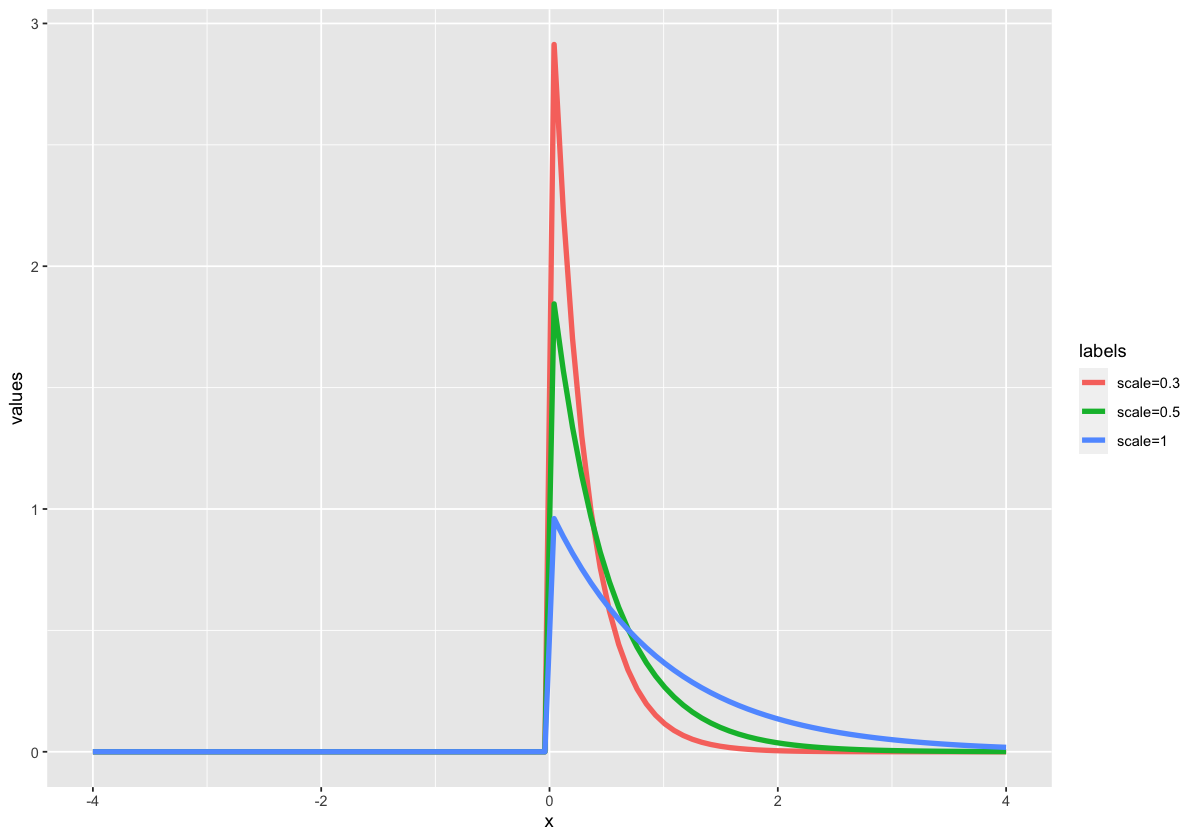

In [20]:
# collapse

x <- seq(-4, 4, length=100)
y1 <- dgpd(x)
y2 <- dgpd(x, scale=0.5)
y3 <- dgpd(x, scale=0.3)

y = append(y1, y2)
y = append(y, y3)
xs = append(x,x)
xs = append(xs, x)
labels = append(rep_len('scale=1', length(x)), rep_len('scale=0.5', length(x)))
labels = append(labels, rep_len('scale=0.3', length(x)))

df = data.frame('values'=unlist(y))
df['x'] = unlist(xs)
df['labels'] = unlist(labels)

ggplot(df, aes(x=x, y=values, color=labels))+geom_line(size=1.5)

&emsp;Below is the plot where $\xi$ changes while $\sigma=1$ <br>
&emsp;If $\xi<0$, it means that this distribution has an upper bound. If $\xi=0$, it becomes $1-exp(-\frac{y}{\tilde{\sigma}})$, which is an exponential distribution. It also means that extremes with lesser magnitudes have a higher probability of occurence than would be seen in distributions where $\xi>0$. In other words, distributions with $\xi>0$ would be a better fit for values at the very right end of the distribution.

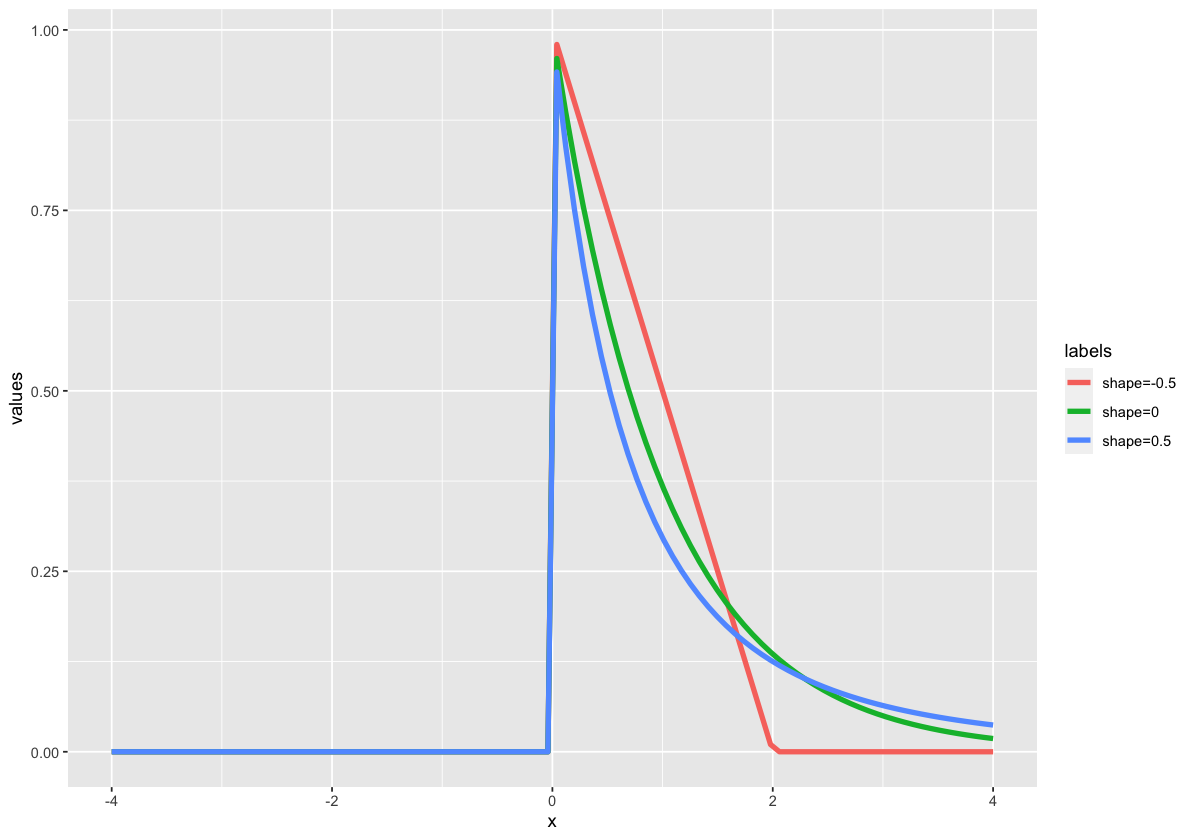

In [22]:
# collapse

x <- seq(-4, 4, length=100)
y1 <- dgpd(x, shape=-0.5)
y2 <- dgpd(x, shape=0)
y3 <- dgpd(x, shape=0.5)

y = append(y1, y2)
y = append(y, y3)
xs = append(x,x)
xs = append(xs, x)
labels = append(rep_len('shape=-0.5', length(x)), rep_len('shape=0', length(x)))
labels = append(labels, rep_len('shape=0.5', length(x)))

df = data.frame('values'=unlist(y))
df['x'] = unlist(xs)
df['labels'] = unlist(labels)

ggplot(df, aes(x=x, y=values, color=labels))+geom_line(size=1.5)

### Starting off with creating sample data

&emsp;As explained before, we want to understand how frequent some extreme events will happen.<br>
&emsp;The data we will be working on is about the weather data from Fort Collins, Colorado, U.S.A. from 1900 to 1999, and focus on the precipitaion. Other datasets can be found in the [extRemes package documentation page 4](https://cran.r-project.org/web/packages/extRemes/extRemes.pdf).<br>
&emsp;So in this case, it will be the return period of heavy rainfall.

&emsp;We'll go through the process of choosing the right threshold, fitting the distribution to the data, and assessing the result.<br>


In [149]:
# collapse

data(FCwx)
df = FCwx
head(df)

,Year,Mn,Dy,MxT,MnT,Prec,Snow,SnCv
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1900,1,1,39,10,0,0,NA
2,1900,1,2,43,9,0,0,NA
3,1900,1,3,55,23,0,0,NA
4,1900,1,4,50,24,0,0,NA
5,1900,1,5,50,16,0,0,NA
6,1900,1,6,52,10,0,0,NA


&emsp;The histogram looks like below, and it seems that the precipitation goes up to 400.

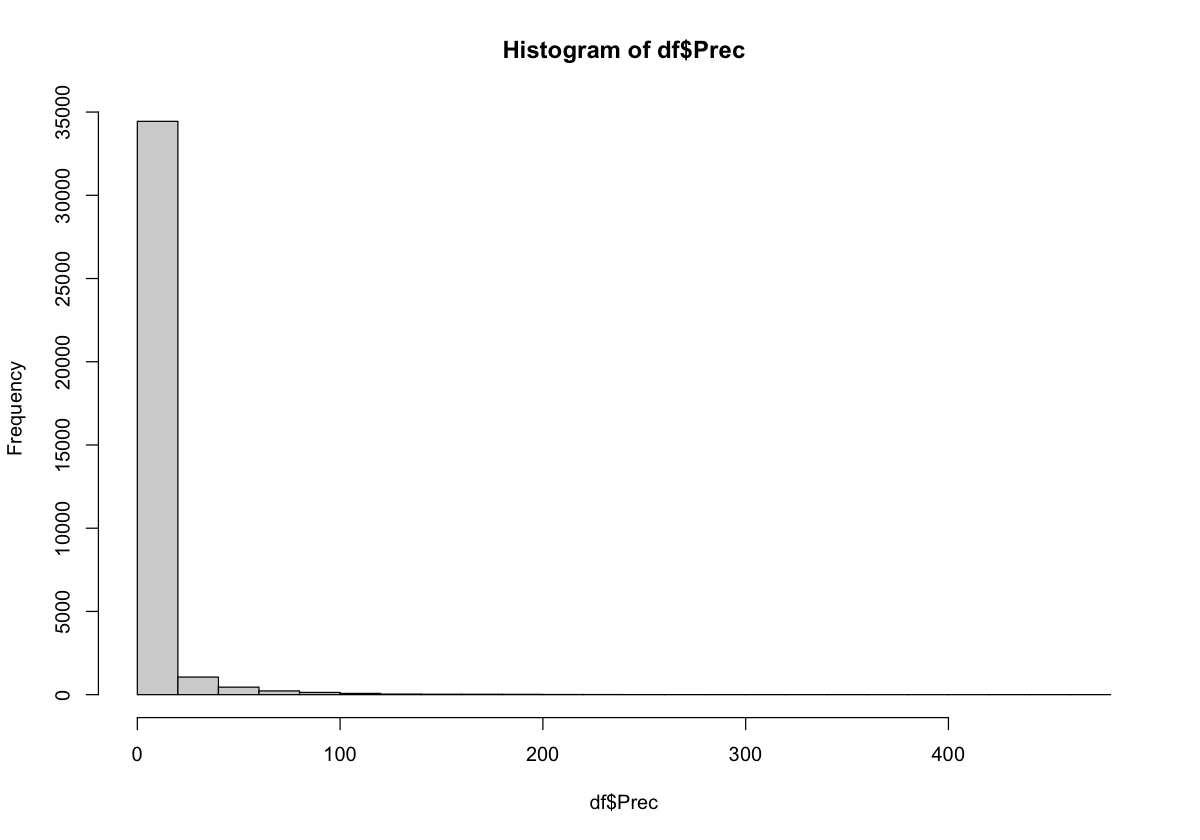

In [152]:
# collapse

hist(df$Prec)

### Setting the threshold

Now, to get the specific threshold, we will use the method proposed by Embrechts (2003); finding a threshold where the excess mean plot is linear.
- Start from the mean of the pareto distribution 
    - $E(y)=\frac{\sigma}{1-\xi}$ where $\xi<1$
- We hypothesized that the exceedent of $\mu_{0}$ follows a pareto distribution.
    - Then the mean becomes $E(X-\mu_{0}|X>\mu_{0})=\frac{\sigma_{\mu_{0}}}{1-\xi}$
- If the data points above threshold $\mu$ follows a pareto distribution, it also means that characteristics of pareto distribution should stand all thresholds above $\mu_0$.
    - $E(X-\mu_{0}|X>\mu_{0})=\frac{\sigma_{\mu}}{1-\xi}$ 
    - = $\frac{\sigma_{\mu_{0}}+\xi\mu}{1-\xi}$
- Thus, we could say that $E(X-\mu_{0}|X>\mu_{0})$ is a linear function of $\mu$. In other words, these estimates are expected to change linearly with $\mu$ when generalized distribution is appropriate.
    - __The appropriate threshold then would be the one where the mean residual life plot is approximately linear in $\mu$__
    - The `mean residual life plot` draws the mean excess for each threshold.

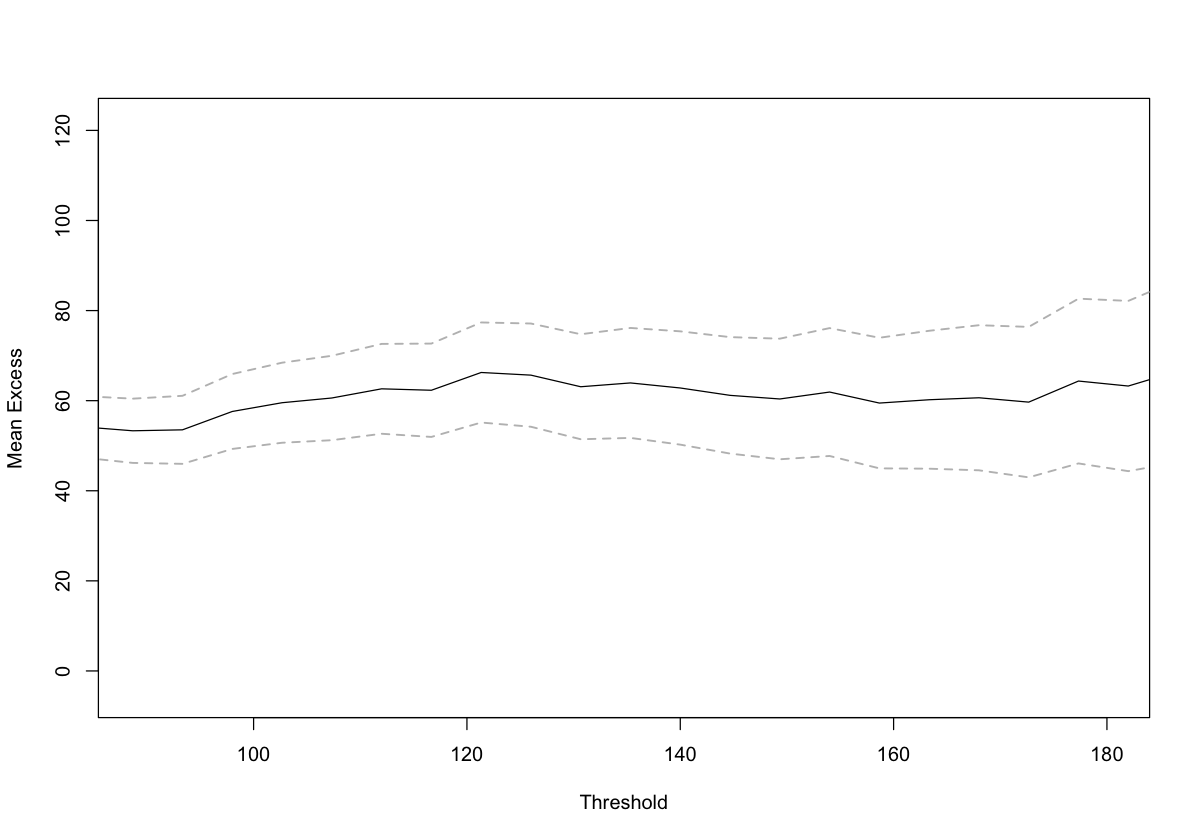

In [159]:
# collapse

quantile_1 = quantile(df$Prec, 0.994)[[1]]
quantile_2 = quantile(df$Prec, 0.998)[[1]]

mrlplot(df$Prec, xlim = c(0.9*quantile_1, 1.1*quantile_2))

&emsp;Usually, the area of interest should be set first. For now, lets say we are interested in cases where there are more than 100mm rainfall. <br>
&emsp;From the mean excess plot above, it seems the threshold that are close to 120 or 135 seems to have a flat mean excess. Those could be the potential threshold candidates.

&emsp;The next step would be to approximate the parameters for a sequence of parameters. As it was in the `mean excess plot`, we are trying to find a threshold that would have a stable distribution. Here, threshold around 105 or 120 seems okay. We also want to find the smallest threshold because that would be the first value that satisfies the following condition: &emsp;&emsp;$E(X-\mu_{0}|X>\mu_{0})$ is a linear function of $\mu$.

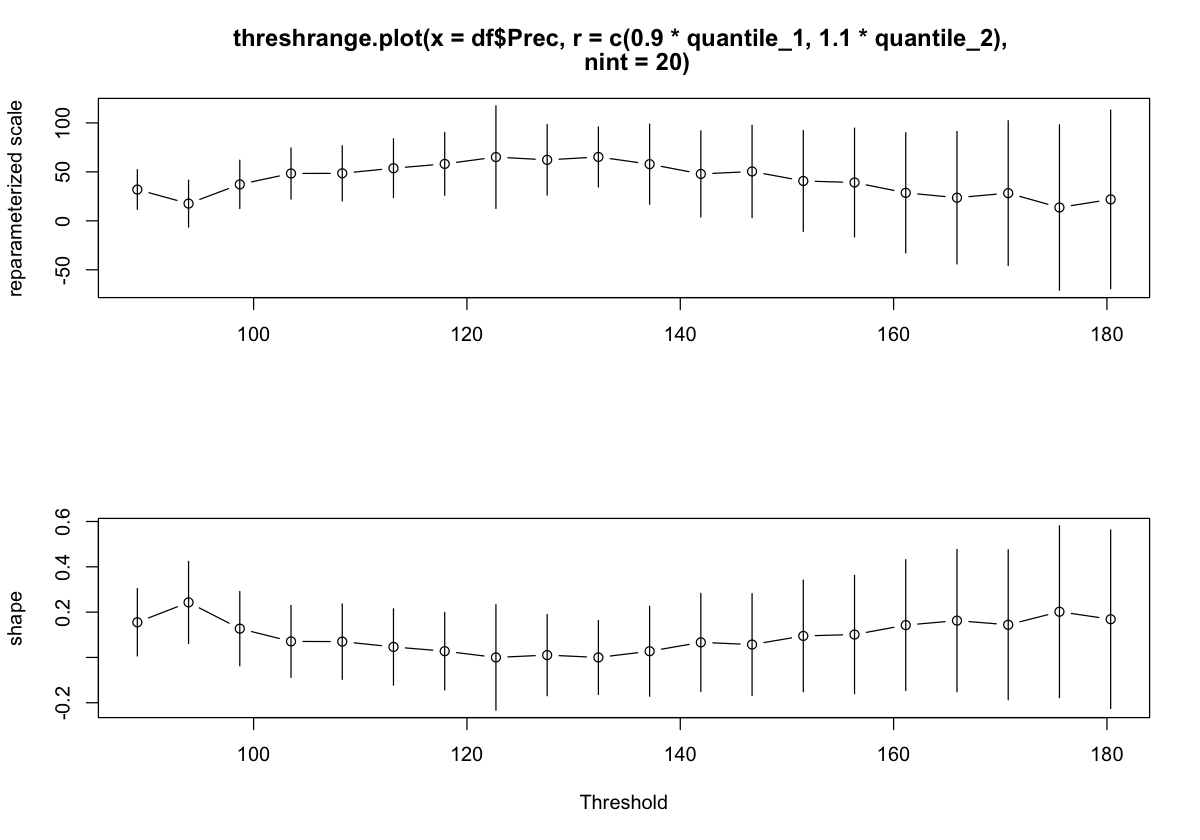

In [160]:
# collapse

threshrange.plot(df$Prec, r = c(0.9*quantile_1, 1.1*quantile_2), nint = 20)

Lets try to fit a threshold to the Generalized pareto distribution.

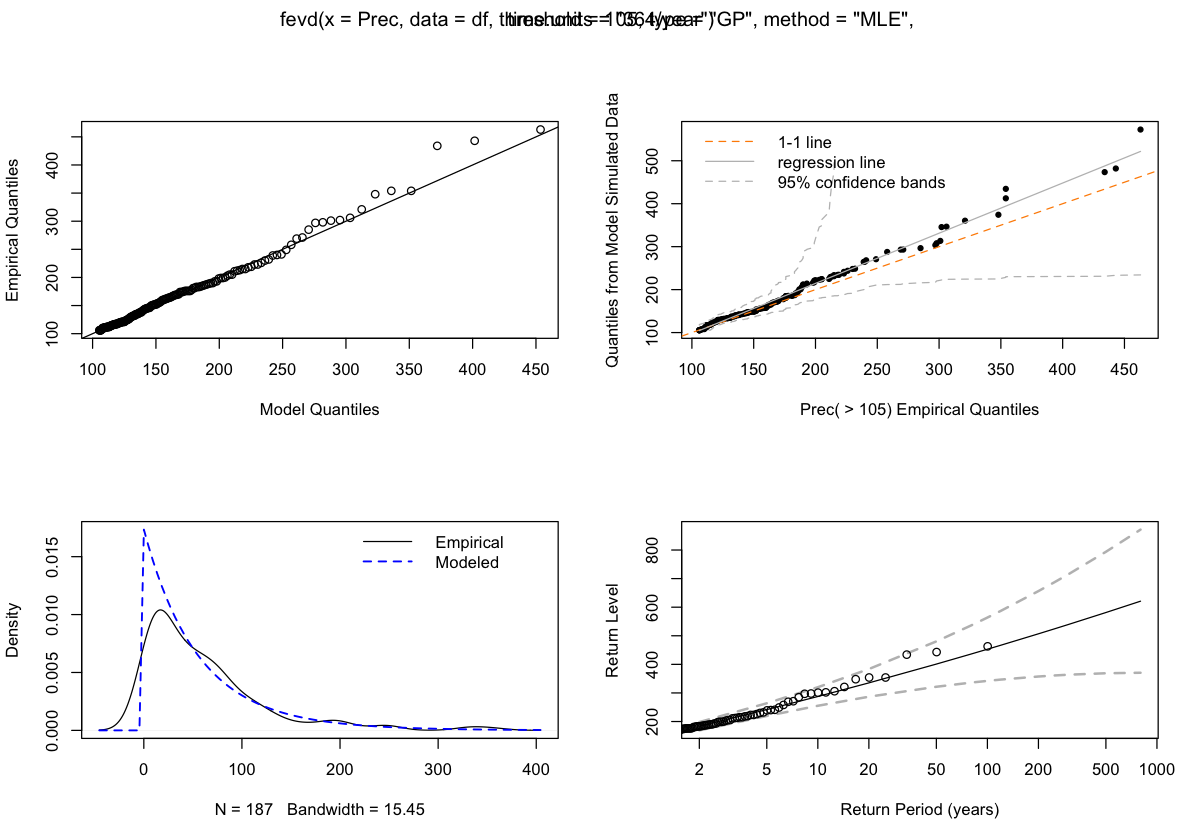

In [186]:
# collapse

df[is.na(df)] <- 0 # input zero for missing precipiation values. The function does not allow missing values
fitL <- fevd(Prec, df, threshold = 105, type = "GP", time.units = "364/year", method='MLE')
# time.units is set to 364/year since our data is a daily rainfall data
plot(fitL)

&emsp;The Q-Q plot on the left indicates that the current distribution is quite okay. However, are there better parameters? How do we know?

&emsp;As the threshold changes the distribution of the output, the VaR value driven by the distribution will also change. Thus, it is CRITICAL to choose a threshold where the result distribution is stable in order to have a reliable result.
&emsp;The concept we could apply here would be to simply run all the possible experiments and choose the best threshold and parameters. Then, what does it mean to have the 'best threshold and parameters'?

&emsp;The best parameters are the ones that best fit the data points. And we would use `back-testing` to compare the results of different thresholds and parameters.

### Back-testing for model assessment

These are helper functions for this exercise.

In [216]:
# collapse

calc_var = function(data_vector, threshL, fit_params, q){
    # calculate the VaR for each quantile.
  rate = sum(data_vector > threshL) / length(data_vector)
  scale = fitL['results'][[1]]['par'][[1]]['scale'][[1]]
  shape = fitL['results'][[1]]['par'][[1]]['shape'][[1]]
  
  var = threshL + (scale/shape) * ( ( (1/rate) * (1-q) )^(-1*shape) -1 )
  
  return (var)
}


backtest = function(quantile_list, data_vector, threshL, fit_params, empirical){
    # perform backtest 
    
    # no need to calculate the VaR for empirical dataset
    # only need to fetch the value for each quantile
  if (empirical==TRUE){
    observed = quantile(data_vector, probs = quantile_list)
    
    q_df = as.data.frame(observed)
    q_df['num_data_used'] = rep.int(length(data_vector), length(quantile_list))
    q_df['quantiles'] = unlist(quantile_list)
    rownames(q_df) = NULL
  }
  else{
      # for already fitted distribution, calculate the value that corresponds for each quantile
    observed = list()
    
    for (q in quantile_list){
      VaR = calc_var(data_vector, threshL, fit_params, q)
      observed = append(observed, VaR)
    }
    
    q_df = as.data.frame(unlist(observed))
    colnames(q_df) = c('observed')
    q_df['num_data_used'] = rep.int(sum(data_vector > threshL), length(quantile_list))
    q_df['quantiles'] = unlist(quantile_list)
    rownames(q_df) = NULL
  }
  
  num_over_thresh_list = list()
  for (th in q_df$observed){
    num_over_thresh = sum(data_vector>th)
    num_over_thresh_list = append(num_over_thresh_list, num_over_thresh)
  }
  q_df['num_over_thresh'] = unlist(num_over_thresh_list)
  
  return (q_df)
}

The basic concept of back-testing here is like this:
- If the distribution correctly represents the data, the percentage of the rainfall exceeding VaR should be equal to the percentage of the rainfall exceeding 1-q(quantile) of the actual data.
Lets go through an example.

![](my_icons/02_/back-testing-example.PNG)

Quantile 0.999.
- Lets say the value for 0.999 quantile of the observational data is $a$. There are 7 observations that goes over $a$.
- For GPD distribution where the threshold is 1.7659, lets say the value for 0.999 quantile is $b$. There are 6 observations that goes over $b$
- The GP distribution that is closest to the `(1-q) observations` for each quantile would be the most appropriate one.

In order to come up with the VaR value for each quantile, we could use the GP distribution and the estimated parameters

$\hat F(x) = 1- rate*[1+\frac{\hat \xi}{\hat \sigma}(x-\mu)]^{-\frac{1}{\hat \xi}}$

- $\mu$ is the threshold
- $\sigma$ is the scale parameter
- $\xi$ is the shape parameter
- $rate=\frac{num\;data\;points\;over\;threshold}{num\;data\;points}$

Using the calculation above, the VaR would be:
$VaR_{q} = \mu + \frac{\hat \sigma}{\hat \xi}[ \{ {\frac{1}{rate}(1-q)} \}^{-\xi} -1]$ where $q>F(\mu)$

__The experiment would be the following:__
- Test for different thresholds.
    - Since 105 and 120 are potential candidates, test with different threshold around those values
- Compare the number of datat that exceeds different quantiles.
    - Compare between the results from empirical dataset and the distribution


```r
threshold_list = c(100, 105, 107, 110, 115, 120, 125, 130)
quantile_list = c(0.99900, 0.9995, 0.9996, 0.9997, 0.9998, 0.99983, 0.99985, 0.99987, 0.99990, 0.99993, 0.99995, 0.99997, 0.99999)
```

In [166]:
# collapse

threshold_list = c(100, 105, 107, 110, 115, 120, 125, 130)
quantile_list = c(0.99900, 0.9995, 0.9996, 0.9997, 0.9998, 0.99983, 0.99985, 0.99987, 0.99990, 0.99993, 0.99995, 0.99997, 0.99999)

backtest_df = backtest(quantile_list, df$Prec, None, fit_params, empirical =  TRUE)
backtest_df['threshold'] = rep_len("Empirical", length(nrow(backtest_df)))

print("Back test results for empirical dataset.")
print(backtest_df)

[1] "Back test results for empirical dataset."
   observed num_data_used quantiles num_over_thresh threshold
1  199.0000         36524   0.99900              36 Empirical
2  239.7385         36524   0.99950              19 Empirical
3  262.2988         36524   0.99960              15 Empirical
4  297.0431         36524   0.99970              11 Empirical
5  304.7816         36524   0.99980               8 Empirical
6  317.8663         36524   0.99983               7 Empirical
7  335.0818         36524   0.99985               6 Empirical
8  349.5121         36524   0.99987               5 Empirical
9  354.0000         36524   0.99990               3 Empirical
10 389.4712         36524   0.99993               3 Empirical
11 435.5646         36524   0.99995               2 Empirical
12 442.1388         36524   0.99997               2 Empirical
13 455.6954         36524   0.99999               1 Empirical


- There are 36 data points that goes over 199mm. 19 that goes over 239.7 ...
- The target is to find backtesting results that would have similar results as this one.
- The number of data points that goes over a certain value indicates the return period. Having similar back-testing result would mean that the distribution correctly reflects the return period.

<font color='blue'>Experiment1: Threshold 100</font>

In [229]:
# collapse

threshL = 100
fitL <- fevd(Prec, df, threshold = threshL, type = "GP", 
               time.units = "364/year", method = "MLE")
fit_params <- fitL

backtest_df = backtest(quantile_list, df$Prec, threshL, fit_params, empirical=FALSE)
backtest_df['threshold'] = rep.int(threshL, length(nrow(backtest_df)))

print(paste("Back test results for threshold:", threshL))
print(backtest_df)

[1] "Back test results for threshold: 100"
   observed num_data_used quantiles num_over_thresh threshold
1  201.1260           213   0.99900              35       100
2  245.9984           213   0.99950              17       100
3  261.1154           213   0.99960              15       100
4  281.1067           213   0.99970              13       100
5  310.2728           213   0.99980               7       100
6  322.2977           213   0.99983               6       100
7  331.6921           213   0.99985               6       100
8  342.5772           213   0.99987               6       100
9  362.9414           213   0.99990               3       100
10 391.4928           213   0.99993               3       100
11 419.3722           213   0.99995               3       100
12 463.5238           213   0.99997               0       100
13 566.4377           213   0.99999               0       100


<font color='blue'>Experiment1: Threshold 105</font>

In [225]:
# collapse

threshL = 105
fitL <- fevd(Prec, df, threshold = threshL, type = "GP", 
               time.units = "364/year", method = "MLE")
fit_params <- fitL

backtest_df = backtest(quantile_list, df$Prec, threshL, fit_params, empirical=FALSE)
backtest_df['threshold'] = rep.int(threshL, length(nrow(backtest_df)))

print(paste("Back test results for threshold:", threshL))
print(backtest_df)

[1] "Back test results for threshold: 105"
   observed num_data_used quantiles num_over_thresh threshold
1  203.3588           187   0.99900              34       105
2  247.7954           187   0.99950              17       105
3  262.4579           187   0.99960              15       105
4  281.6233           187   0.99970              13       105
5  309.1453           187   0.99980               7       105
6  320.3468           187   0.99983               7       105
7  329.0407           187   0.99985               6       105
8  339.0527           187   0.99987               6       105
9  357.6109           187   0.99990               3       105
10 383.2649           187   0.99993               3       105
11 407.9224           187   0.99995               3       105
12 446.2225           187   0.99997               1       105
13 532.2563           187   0.99999               0       105


<font color='blue'>Experiment1: Threshold 110</font>

In [226]:
# collapse

threshL = 110
fitL <- fevd(Prec, df, threshold = threshL, type = "GP", 
               time.units = "364/year", method = "MLE")
fit_params <- fitL

backtest_df = backtest(quantile_list, df$Prec, threshL, fit_params, empirical=FALSE)
backtest_df['threshold'] = rep.int(threshL, length(nrow(backtest_df)))

print(paste("Back test results for threshold:", threshL))
print(backtest_df)

[1] "Back test results for threshold: 110"
   observed num_data_used quantiles num_over_thresh threshold
1  202.4413           174   0.99900              35       110
2  246.9875           174   0.99950              17       110
3  261.8145           174   0.99960              15       110
4  281.2898           174   0.99970              13       110
5  309.4425           174   0.99980               7       110
6  320.9628           174   0.99983               7       110
7  329.9287           174   0.99985               6       110
8  340.2804           174   0.99987               6       110
9  359.5426           174   0.99990               3       110
10 386.3278           174   0.99993               3       110
11 412.2432           174   0.99995               3       110
12 452.8246           174   0.99997               1       110
13 545.4017           174   0.99999               0       110


<font color='blue'>Experiment1: Threshold 120</font>

In [227]:
# collapse

threshL = 120
fitL <- fevd(Prec, df, threshold = threshL, type = "GP", 
               time.units = "364/year", method = "MLE")
fit_params <- fitL

backtest_df = backtest(quantile_list, df$Prec, threshL, fit_params, empirical=FALSE)
backtest_df['threshold'] = rep.int(threshL, length(nrow(backtest_df)))

print(paste("Back test results for threshold:", threshL))
print(backtest_df)

[1] "Back test results for threshold: 120"
   observed num_data_used quantiles num_over_thresh threshold
1  206.0287           138   0.99900              32       120
2  250.9731           138   0.99950              16       120
3  265.4544           138   0.99960              15       120
4  284.1330           138   0.99970              13       120
5  310.4762           138   0.99980               7       120
6  321.0407           138   0.99983               6       120
7  329.1792           138   0.99985               6       120
8  338.4863           138   0.99987               6       120
9  355.5567           138   0.99990               3       120
10 378.7767           138   0.99993               3       120
11 400.6958           138   0.99995               3       120
12 433.9995           138   0.99997               3       120
13 505.7326           138   0.99999               0       120


__Overall, here are the findings:__
- The backtest results for threshold 105 and 110 are most similar to the empirical results
- Threshold 105 represents the empirical dataset better, than threshold 100
    - Could see it captures the value at 0.99997 while the distribution with threshold 100 cannot
- Increasing the threshold to 110 has similar result meaning the 'look' of the distribution is stable. Thus 105 is an appropriate choice
- Increasing the threshold to 120 deviates the back-testing results from the empirical observations

### Final look of the model

In [230]:
# collapse

threshL = 105
fitL <- fevd(Prec, df, threshold = threshL, type = "GP", 
               time.units = "364/year", method = "MLE")

In [231]:
summary(fitL)


fevd(x = Prec, data = df, threshold = threshL, type = "GP", method = "MLE", 
    time.units = "364/year")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  955.3269 


 Estimated parameters:
      scale       shape 
57.61372105  0.05392585 

 Standard Error Estimates:
     scale      shape 
6.23291161 0.07997853 

 Estimated parameter covariance matrix.
           scale        shape
scale 38.8491872 -0.350636171
shape -0.3506362  0.006396566

 AIC = 1914.654 

 BIC = 1921.116 


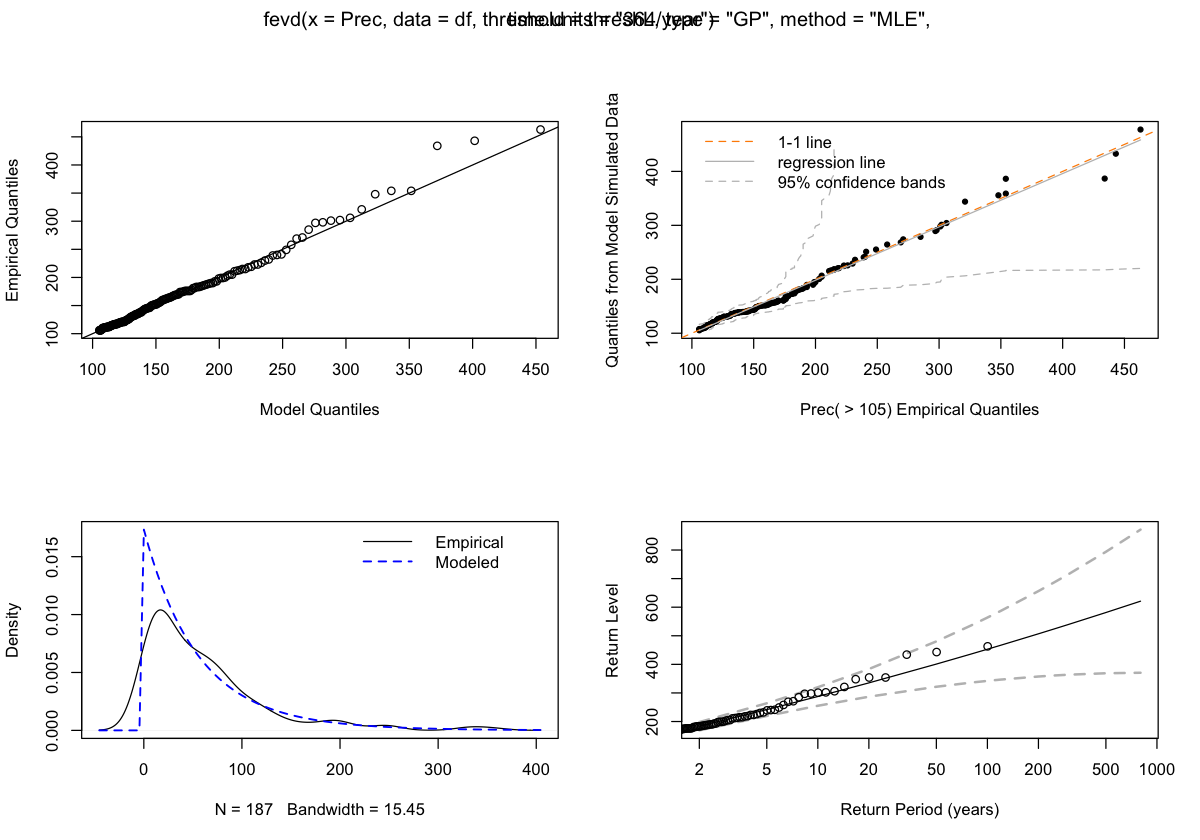

In [232]:
plot(fitL)

### Utilizing the model

With the distribution we derived, we could calculate the return period of extreme events. <br>
The return period would be the inverse of $[1 + \frac{\xi (y-\mu)}{\sigma} ]^{\frac{- 1}{\xi}}*rate*ndays$, where $rate=\frac{num\;data\;points\;over\;threshold}{num\;data\;points}$

In [242]:
# collapse

return.level(fitL, return.period = 2:10)

fevd(x = Prec, data = df, threshold = threshL, type = "GP", method = "MLE", 
    time.units = "364/year")
get(paste("return.level.fevd.", newcl, sep = ""))(x = x, return.period = return.period)

 GP model fitted to  Prec df 
Data are assumed to be  stationary 
[1] "Covariate data = df"
[1] "Return Levels for period units in years"
 2-year level  3-year level  4-year level  5-year level  6-year level 
     183.5553      208.9094      227.2377      241.6512      253.5574 
 7-year level  8-year level  9-year level 10-year level 
     263.7157      272.5837      280.4590      287.5463 

<br><br>
And for very extreme cases such as 200 year return period, the result is like below. <br>
506mm of rain will fall in every 200 years.

In [241]:
return.level(fitL, return.period = 200)

fevd(x = Prec, data = df, threshold = threshL, type = "GP", method = "MLE", 
    time.units = "364/year")
get(paste("return.level.fevd.", newcl, sep = ""))(x = x, return.period = return.period)

 GP model fitted to  Prec df 
Data are assumed to be  stationary 
[1] "Covariate data = df"
[1] "Return Levels for period units in years"
200-year level 
      506.8702 

---
END